# Recommender System - 기본 과제 \#1

## 개요

1. SGD 기반 MF 모델을 구현해본다.
2. ALS 기반 MF 모델을 구현해본다.


- 과제는 **<font color=#5F71F7>과제 HOMEWORK</font>** 라는 키워드로 표시하였습니다.
- <code><font color=#007979># FILL HERE : ... #</font></code>라고 쓰여 있는 부분을 채워넣으시면 됩니다.

---

## 0. 데이터 불러오기

### 0.1. 기본 설정

In [2]:
from typing import Union, Tuple, List

import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

### 0.2. random seed 고정

In [3]:
seed = 0

random.seed(seed)
np.random.seed(seed)

### 0.3. MovieLens 데이터셋 불러오기


#### 활용 데이터셋 : MovieLens Latest Dataset (small)

- 출처 :
    <br>Harper, F. M., & Konstan, J. A. (2015). **The MovieLens Datasets: History and Context.** ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. http://dx.doi.org/10.1145/2827872
    
    
- 본 데이터셋은 직접 GroupLens 측을 통해 Naver Boostcamp RecSys 강좌 내에서 활용 및 재배포를 허가받은 데이터셋입니다.
    <br> 과제 외의 목적으로 이용하고자 할 경우 [원시 데이터](https://grouplens.org/datasets/movielens/)를 직접 다운받아 사용하시기 바랍니다.
    <br> ( 각 데이터셋에 대한 README.txt 파일을 통해 라이센스 정보를 확인하실 수 있습니다. )

In [4]:
base_path = os.path.join(os.curdir, 'data')
data_path = os.path.join(base_path, 'ml-latest-small')

In [5]:
rating_path = os.path.join(data_path, 'ratings.csv')

# 무비렌즈 학습 데이터
ratings_df = pd.read_csv(rating_path, encoding='utf-8')

---

## 1. SGD 기반 MF 모델 구현하기

- SGD: Stochastic Gradient Descent
- MF: Matrix Factorization

### <font color='#5F71F7'>과제 HOMEWORK (1)</font> 
### 1.1. MF 모델의 파라미터를 업데이트하는 SGD를 구현하라.

<p style="font-size:20px">
$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u )$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i )$$
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u )$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i )$$
</p>

In [300]:
def sgd(
    P: np.ndarray,
    Q: np.ndarray,
    b: float,
    b_u: np.ndarray,
    b_i: np.ndarray,
    samples: List[Tuple],
    learning_rate: float,
    regularization: float
) -> None:
    """
    MF 모델의 파라미터를 업데이트하는 SGD를 구현하자.
    
    ***********************************************************************************************************
    SGD:
        모든 학습 데이터에 대하여
        1. 현재 주어진 파라미터로 predicted rating을 구함
        2. 실제 rating과 predicted rating의 차이로 error를 구함
        3. 2.에서 구한 error를 통해 유저와 아이템의 bias 업데이트 - 위 수식의 첫 두 줄
        4. 2.에서 구한 error를 통해 유저와 아이템의 잠재 요인 행렬 업데이트 - 위 수식의 아래 두 줄
    ***********************************************************************************************************
    
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param b: (float) 글로벌 bias
    :param b_u: (np.ndarray) 유저별 bias
    :param b_i: (np.ndarray) 아이템별 bias
    :param samples: (List[Tuple]) 학습 데이터 (실제 평가를 내린 데이터만 학습에 사용함)
                    (user_id, item_id, rating) tuple을 element로 하는 list임
    :param learning_rate: (float) 학습률 
    :param regularization: (float) l2 정규화 파라미터 람다
    :return: None
    """
    for user_id, item_id, rating in samples:
        
        # 1. 현재 주어진 파라미터로 predicted rating을 구함
        predicted_rating = P[user_id,:].dot(Q[item_id,:].T) + b_i[item_id] + b_u[user_id] + b
        
        # 2. 실제 rating과 predicted rating의 차이로 error를 구함
        error = rating-predicted_rating
        
        # 3. 2.에서 구한 error를 통해 유저와 아이템의 bias 업데이트
        b_u[user_id] += learning_rate * (error-regularization*b_u[user_id])
        b_i[item_id] += learning_rate * (error-regularization*b_i[item_id])
        
        # 4. 2.에서 구한 error를 통해 유저와 아이템의 잠재 요인 행렬 업데이트
        P[user_id, :] += learning_rate * (error*Q[item_id,:] - regularization*P[user_id,:])
        Q[item_id, :] += learning_rate * (error*P[user_id,:] - regularization*Q[item_id,:])

### <font color='#5F71F7'>과제 HOMEWORK (2)</font> 
### 1.2. 유저와 아이템의 잠재 요인 행렬($P$, $Q$)과 글로벌, 유저, 아이템 bias($b$, $b_u$, $b_i$)를 활용하여 예측된 유저-아이템 rating 매트릭스($\hat{R}$)를 구하는 함수를 구현하라

- bias가 없을 때
<p style="font-size:20px">$$\hat{R} = PQ^T$$</p>
- bias가 있을 때
<p style="font-size:20px">$$\hat{R} = PQ^T + \mathbb{1}_{|U|}b_i ^ T + b_u \mathbb{1}_{|I|}^{T} + b \mathbb{1}_{|U|} \mathbb{1}_{|I|}^{T} $$</p>


In [301]:
def get_predicted_full_matrix(
    P: np.ndarray,
    Q: np.ndarray,
    b: float = None,
    b_u: np.ndarray = None,
    b_i: np.ndarray = None
) -> np.ndarray:
    """
    유저와 아이템의 잠재 요인 행렬과 글로벌, 유저, 아이템 bias를 활용하여 예측된 유저-아이템 rating 매트릭스를 구하라.
    
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param b: (float) 글로벌 bias
    :param b_u: (np.ndarray) 유저별 bias
    :param b_i: (np.ndarray) 아이템별 bias
    :return: (np.ndarray) 예측된 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    """
    if b is None:
        return P.dot(Q.T)
    else:
        
        return P.dot(Q.T) + b_i + b_u.reshape(610,1) + b

### <font color='#5F71F7'>과제 HOMEWORK (3)</font> 
### 1.3.  1.2.에서 구한 $\hat{R}$를 활용하여 전체 학습 데이터에 대한 RMSE를 계산하는 함수를 구현하라.
<p style="font-size:20px">$$RMSE(\hat{\theta}) = \sqrt{MSE(\hat{\theta})} = \sqrt{\mathbb{E}({(\hat{\theta} - \theta)}^2)}$$</p>

- RMSE: Root Mean Square Error; 평균 제곱근 오차

- <font color="red">주의) </font> 실제 평가를 내린 데이터에 대해서만 RMSE를 계산하여야 한다.

- <font color="blue">힌트) </font> [<code>numpy.ndarray.nonzero()</code>](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.nonzero.html) 함수를 활용하라.

In [302]:

def get_rmse(
    R: np.ndarray,
    predicted_R: np.ndarray
) -> float:
    """
    전체 학습 데이터(실제 평가를 내린 데이터)에 대한 RMSE를 계산하라.
    
    ***********************************************************************************************************
    주의) 실제 평가를 내린 데이터에 대해서만 rmse를 계산하여야 한다.
    ***********************************************************************************************************
    
    :param R: (np.ndarray) 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    :param predicted_R: (np.ndarray) 예측된 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    :return: (float) 전체 학습 데이터에 대한 RMSE
    """
    user_index, item_index = R.nonzero()
    error = list()
    for user_id, item_id in zip(user_index, item_index):
        square_error = (R[user_id][item_id] - predicted_R[user_id][item_id])
        error.append(square_error)
    error = np.array(error)
    rmse = np.sqrt(np.mean(error**2))
    return rmse
    

### 1.4. MF 구현
- 1.1 ~ 1.3 에서 구현한 함수들을 활용하여 MF를 구현하고, 이를 바탕으로 MovieLens 데이터로 학습해본다.

In [303]:
class MF(object):
    
    def __init__(self, R, K, learning_rate, regularization, epochs, verbose=False):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose
        
        self.training_process = list()
    
    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # 글로벌, 유저, 아이템 bias 초기화
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        for epoch in range(1, self.epochs + 1):
            np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.b, self.b_u, self.b_i, self.samples, self.learning_rate, self.regularization)
            predicted_R = self.get_predicted_full_matrix()
            rmse = get_rmse(self.R, predicted_R)
            self.training_process.append((epoch, rmse))
            if self.verbose and (epoch % 10 == 0):
                print("epoch: %d, error = %.4f" % (epoch, rmse))
        
        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])
    
    def get_predicted_full_matrix(self):
        return get_predicted_full_matrix(self.P, self.Q, self.b, self.b_u, self.b_i)

---

## 2. SVD 기반 MF 모델 실습
### 2.1. 학습 데이터, 하이퍼 파라미터 초기화

In [304]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

# 유저-아이템 rating 매트릭스
R = user_item_matrix.to_numpy()

# 잠재 요인 수
K = 20

# learning rate
learning_rate = 0.01

# l2 정규화 파라미터
regularization = 0.2

# 총 epoch 수
epochs = 30

# 학습 과정의 status print 옵션
verbose = True

In [305]:
mf = MF(R, K, learning_rate, regularization, epochs, verbose)


### 2.2. 모델 학습하기

In [306]:
mf.train()

epoch: 10, error = 0.8352
epoch: 20, error = 0.8205
epoch: 30, error = 0.8132


### 2.3. epoch에 따른 training error (RMSE) 결과 도식화

- 아래와 동일한 결과가 나와야 함

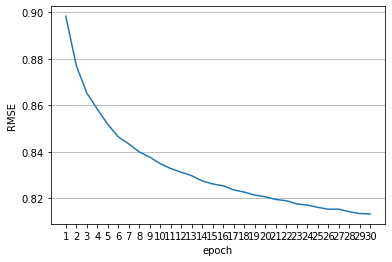

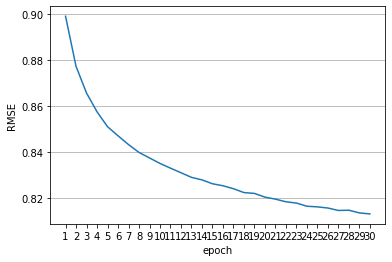

In [307]:
train_result_df = mf.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

### 2.4. 기존 유저-아이템 rating 매트릭스

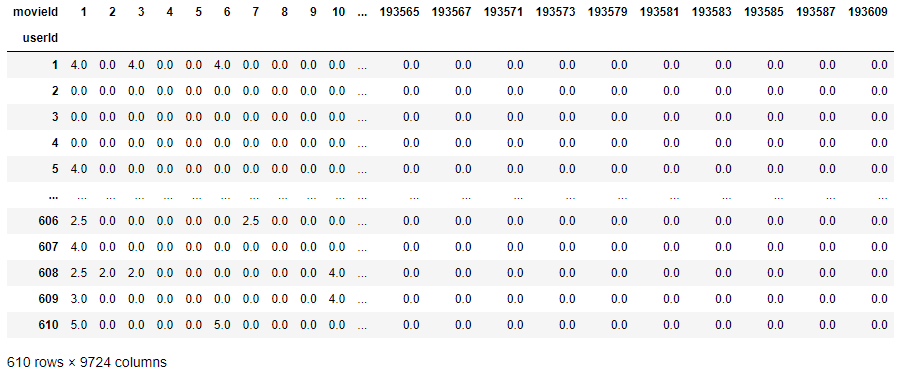

### 2.5.  예측된 유저-아이템 rating 매트릭스

- 아래와 동일한 결과가 나와야 함

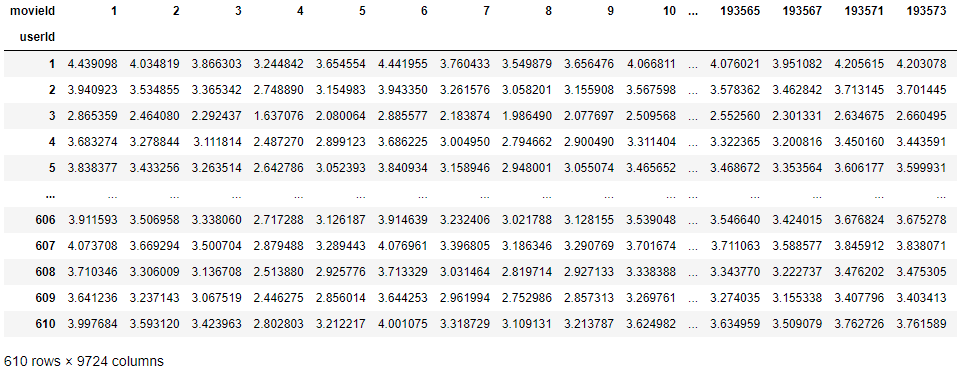

In [309]:
predicted_user_item_matrix = pd.DataFrame(mf.get_predicted_full_matrix(), columns=user_item_matrix.columns, index=user_item_matrix.index)

predicted_user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.507042,4.135072,3.950161,3.325043,3.713286,4.535647,3.827989,3.629863,3.731504,4.128752,...,4.156997,4.030834,4.283906,4.281295,4.159856,4.282648,4.157552,4.157199,4.157439,4.312989
2,3.921905,3.551400,3.367600,2.748196,3.128436,3.950047,3.245588,3.047349,3.151806,3.546292,...,3.565393,3.450256,3.685701,3.707332,3.578672,3.694271,3.573933,3.576782,3.569360,3.721171
3,2.864611,2.487611,2.298888,1.626660,2.076805,2.883939,2.188440,1.959833,2.101360,2.487237,...,2.448730,2.320118,2.643503,2.644150,2.529905,2.587294,2.543970,2.439738,2.583118,2.555602
4,3.698969,3.328620,3.144466,2.531009,2.906362,3.728237,3.021338,2.822896,2.920153,3.324178,...,3.351387,3.239776,3.475981,3.487151,3.358586,3.482297,3.345071,3.362262,3.351364,3.502653
5,3.796793,3.424483,3.239837,2.611381,3.002253,3.824943,3.117593,2.920277,3.021877,3.418553,...,3.447747,3.322973,3.568697,3.571829,3.451697,3.570610,3.448850,3.446901,3.447904,3.600711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.901644,3.529790,3.345162,2.720738,3.108554,3.930208,3.222876,3.024704,3.126058,3.523748,...,3.552519,3.427357,3.676481,3.676783,3.553207,3.675545,3.551268,3.551886,3.552260,3.704828
607,4.043876,3.672271,3.487143,2.862219,3.251239,4.071473,3.364191,3.162648,3.268517,3.665713,...,3.690256,3.566334,3.816528,3.815042,3.696322,3.817680,3.692102,3.694516,3.696232,3.846451
608,3.580408,3.208325,3.022836,2.396439,2.787063,3.608899,2.900144,2.702566,2.805472,3.202183,...,3.229426,3.100601,3.353463,3.353576,3.232676,3.353029,3.229391,3.231247,3.233245,3.385148


---

## 3. ALS 기반 MF 모델 구현하기

- ALS: Alternating Least Square

### <font color='#5F71F7'>과제 HOMEWORK (4)</font> 
### 3.1. MF 모델의 파라미터를 업데이트하는 ALS를 구현하라.

<p style="font-size:20px">
$$p_u = {(Q^{T}C^{u}Q + {\lambda}I)^{-1}Q^{T}C^{u}f_{u}}$$
$$q_i = {(P^{T}C^{i}P + {\lambda}I)^{-1}P^{T}C^{i}f_{i}}$$
</p>

- <font color="blue">힌트) </font> [<code>numpy.linalg.solve()</code>](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) 함수를 활용하라.

In [360]:
def als(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    K: int,
    regularization: float
) -> None:
    """
    MF 모델의 파라미터를 업데이트하는 ALS를 구현하자.
    
    ***********************************************************************************************************
    ALS:
        1. 모든 유저에 대하여 유저의 잠재 요인 행렬을 업데이트 - 위 수식의 첫번째 줄
        2. 모든 아이템에 대하여 아이템의 잠재 요일 행렬 업데이트 - 위 수식의 두번째 줄
    ***********************************************************************************************************
    
    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. shape: (유저 수, 아이템 수)
    :param K: (int) 잠재 요인 수
    :param regularization: (float) l2 정규화 파라미터
    :return: None
    """
    for user_id, F_user in enumerate(F):
       
        C_u = np.diag(C[user_id])
        P[user_id] = np.linalg.solve(Q.T.dot(C_u).dot(Q)+regularization*np.eye(200),np.eye(200)).dot(Q.T).dot(C_u).dot(F_user)
#         P[user_id] = np.linalg.solve(Q.T.dot(C_u).dot(Q)+regularization*np.eye(len(Q)),np.eye(len(Q))).dot(Q.T).dot(C_u).dot(F_user)
        
        # FILL HERE : USE np.linalg.solve()#
        
    for item_id, F_item in enumerate(F.T):
        C_i = np.diag(C[:, item_id])
        Q[item_id] = np.linalg.solve(P.T.dot(C_i).dot(P)+regularization*np.eye(200),np.eye(200)).dot(P.T).dot(C_i).dot(F_item)

### <font color='#5F71F7'>과제 HOMEWORK (5)</font> 
### 3.2. ALS의 Loss Function을 계산하는 함수를 구현하라.


<p style="font-size:20px">
$$\sum_{observed~f_{u,i}} {c_{u,i}{(f_{u,i} - p_{u}^Tq_{i})}^{2} + \lambda(\sum_{u}{||p_u ||}^{2}_{2} + \sum_{i}{||q_i ||}^{2}_{2})}$$
</p>

- <font color="red">주의) </font> 실제 평가를 내린 데이터에 대해서만 RMSE를 계산하여야 한다.

- <font color="blue">힌트) </font> [<code>numpy.ndarray.nonzero()</code>](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.nonzero.html) 함수를 활용하라.

In [362]:
def get_ALS_loss(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    regularization: float
) -> float:
    """
    전체 학습 데이터(실제 평가를 내린 데이터)에 대한 ALS의 Loss를 계산하라.
    
    ***********************************************************************************************************
    주의) 실제 평가를 내린 데이터에 대해서만 ALS의 Loss를 계산하여야 한다.
    ***********************************************************************************************************
    
    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. shape: (유저 수, 아이템 수)
    :param regularization: (float) l2 정규화 파라미터
    :return: (float) 전체 학습 데이터에 대한 Loss
    """
    
    user_index, item_index = F.nonzero()
    loss = 0
    for user_id, item_id in zip(user_index, item_index):
        predict_error = F[user_id][item_id]-P[user_id].T.dot(Q[item_id])
        confidence_error = C[user_id][item_id]*(predict_error**2)
        loss += confidence_error
    for user_id in range(F.shape[0]):
        regularization_term = regularization * (np.linalg.norm(P[user_id],2) ** 2)
        loss += regularization_term
    for item_id in range(F.shape[1]):
        regularization_term = regularization * (np.linalg.norm(Q[item_id],2) ** 2)
        loss += regularization_term

    return loss
    

### 3.3. ALS 기반 MF 구현

- 3.1 ~ 3.2에서 구현한 함수들을 활용하여 ALS로 업데이트하는 MF를 구현하고, 이를 바탕으로 MovieLens 데이터로 학습해본다.

In [363]:
class MF_ALS(object):
    
    def __init__(self, F, K, C, regularization, epochs, verbose=False):
        self.F = F
        self.num_users, self.num_items = F.shape
        self.K = K
        self.C = C
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose
        
        self.training_process = list()
    
    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        for epoch in range(1, self.epochs + 1):
            als(self.F, self.P, self.Q, self.C, self.K, self.regularization)
            loss = get_ALS_loss(self.F, self.P, self.Q, self.C, self.regularization)
            self.training_process.append((epoch, loss))
            if self.verbose and (epoch % 10 == 0):
                print("epoch: %d, error = %.4f" % (epoch, loss))
        
        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])
    
    def get_predicted_full_matrix(self):
        return get_predicted_full_matrix(self.P, self.Q)

---

## 4. ALS 기반 MF 모델 실습

### 4.1. MovieLens 데이터의 일부를 Implicit Feedback 데이터로 변환

In [364]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

In [365]:
user_num = int(user_item_matrix.shape[0] / 10)
movie_num = int(user_item_matrix.shape[1] / 10)
preference_matrix = np.copy(user_item_matrix.iloc[:user_num,:movie_num])
preference_matrix[preference_matrix > 0] = 1

### 4.2. 신뢰도 행렬 $C$, 잠재 요인 수, l2 정규화 파라미터 설정

In [366]:
alpha = 40
# 신뢰도 행렬
C = 1 + alpha * np.copy(preference_matrix)
# 잠재 요인 수
K = 200

# l2 정규화 파라미터
regularization = 40

# 총 epoch 수
epochs = 500

# 학습 과정의 status print 옵션
verbose = True

### 4.3. 모델 학습하기

In [367]:
mf_als = MF_ALS(preference_matrix, K, C, regularization, epochs, verbose)
mf_als.train()

epoch: 10, error = 18654.5213
epoch: 20, error = 18325.9917
epoch: 30, error = 18305.9998
epoch: 40, error = 18302.9867
epoch: 50, error = 18302.1120
epoch: 60, error = 18301.7035
epoch: 70, error = 18301.4633
epoch: 80, error = 18301.3063
epoch: 90, error = 18301.1974
epoch: 100, error = 18301.1186
epoch: 110, error = 18301.0597
epoch: 120, error = 18301.0144
epoch: 130, error = 18300.9786
epoch: 140, error = 18300.9498
epoch: 150, error = 18300.9262
epoch: 160, error = 18300.9064
epoch: 170, error = 18300.8896
epoch: 180, error = 18300.8751
epoch: 190, error = 18300.8626
epoch: 200, error = 18300.8515
epoch: 210, error = 18300.8417
epoch: 220, error = 18300.8330
epoch: 230, error = 18300.8251
epoch: 240, error = 18300.8180
epoch: 250, error = 18300.8116
epoch: 260, error = 18300.8057
epoch: 270, error = 18300.8003
epoch: 280, error = 18300.7954
epoch: 290, error = 18300.7909
epoch: 300, error = 18300.7867
epoch: 310, error = 18300.7828
epoch: 320, error = 18300.7793
epoch: 330, error

### 4.4. epoch에 따른 training error (RMSE) 결과 도식화

- 아래와 동일한 결과가 나와야 함

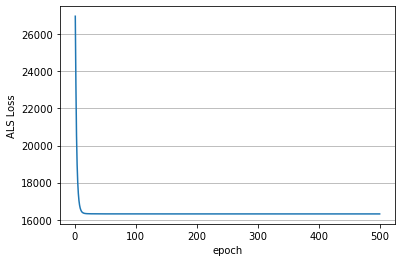

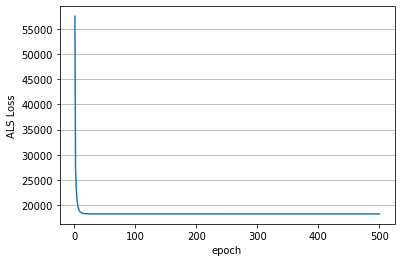

In [368]:
train_result_df = mf_als.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.xlabel("epoch")
plt.ylabel("ALS Loss")
plt.grid(axis="y")
plt.show()

### 4.4. 기존 일부 유저-아이템 rating 매트릭스


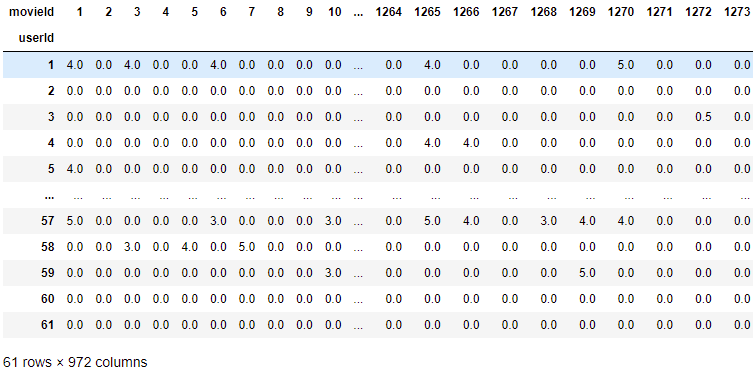

### 4.5.  예측된 유저-아이템 preference 매트릭스

- 아래와 동일한 결과가 나와야 함

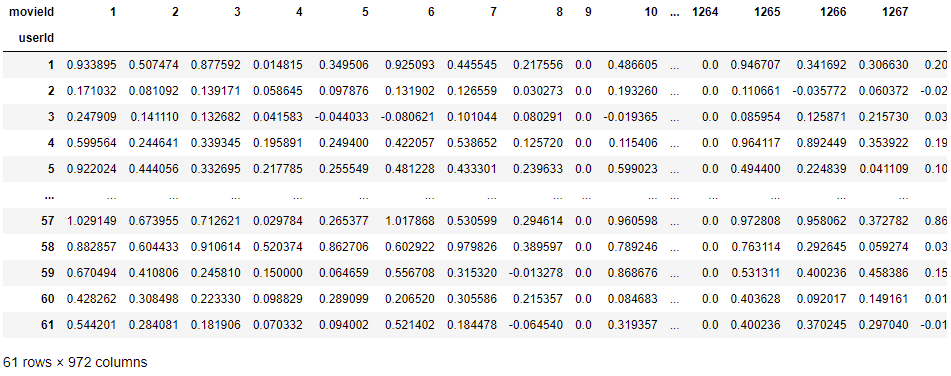

In [369]:
predicted_user_item_preference = pd.DataFrame(mf_als.get_predicted_full_matrix(), columns=user_item_matrix.iloc[:user_num,:movie_num].columns, index=user_item_matrix.iloc[:user_num,:movie_num].index)

predicted_user_item_preference

movieId,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
userId,,,,,,,,,,,,,,,,,,,,,
1,0.933895,0.507474,0.877592,0.014815,0.349507,0.925093,0.445545,0.217556,0.0,0.486605,...,0.0,0.946707,0.341692,0.306630,0.205368,0.324559,0.986604,0.181226,0.193462,0.103790
2,0.171032,0.081092,0.139171,0.058645,0.097876,0.131902,0.126559,0.030273,0.0,0.193260,...,0.0,0.110661,-0.035772,0.060372,-0.024727,0.000958,0.055200,0.005632,0.081579,0.022423
3,0.247909,0.141110,0.132682,0.041583,-0.044033,-0.080621,0.101044,0.080291,0.0,-0.019365,...,0.0,0.085954,0.125871,0.215730,0.036354,0.165880,0.272655,0.125437,0.739039,0.169320
4,0.599564,0.244641,0.339345,0.195892,0.249400,0.422057,0.538652,0.125720,0.0,0.115406,...,0.0,0.964117,0.892449,0.353922,0.197878,0.328940,0.497254,0.320193,0.123395,0.182651
5,0.922024,0.444056,0.332695,0.217785,0.255549,0.481228,0.433301,0.239633,0.0,0.599023,...,0.0,0.494400,0.224839,0.041109,0.101012,0.026739,0.161465,0.310196,0.077717,0.084581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1.029149,0.673955,0.712621,0.029784,0.265377,1.017868,0.530599,0.294614,0.0,0.960598,...,0.0,0.972808,0.958062,0.372782,0.864738,0.928658,0.979270,0.264285,0.304900,0.264621
58,0.882857,0.604433,0.910614,0.520374,0.862706,0.602922,0.979826,0.389597,0.0,0.789246,...,0.0,0.763114,0.292645,0.059274,0.034126,0.082100,0.450132,0.277403,0.104232,-0.057395
59,0.670494,0.410806,0.245810,0.150000,0.064659,0.556708,0.315320,-0.013278,0.0,0.868676,...,0.0,0.531311,0.400236,0.458386,0.159306,0.800586,0.957238,0.117317,0.523431,0.269581
